### Basics of Supervised Learning

Supervised learning composes a little less than one half of machine learning topics. It's for working on problems where you have a quantity you want to predict (either numerical or categorical), you have some data that you think is associated with the quantity, and you have already observed past records of the quantity.

### Examples: 
* Whether or not an account will churn in a given timeframe.
* Whether an opened opportunity will close, be lost, or be abandoned.
* Is this MRI data indicative of a disease? 
* How price sensitive are our consumers?
* What conditions make this piece of UFO hardware emit deadly radiation? (not for beginners.)

### Math:
Formally, it solves the following problem: Given $n$ observations $x_{i}, y_{i}$ where each $x_{i}$ is a list of variables associated with the result $y_{i}$, we want to learn some function $f(X)$ minimizing the error $\mathcal{L}(f(X), Y)$, for observations which are *not in the sample*.

* $x_{i}, y_{i}$ are _observations_, which we number $i = 1, ..., n$. Each $x_{i}$ is information that you think relates to what value $y_{i}$ assumes. We use capital letters $X, Y$ when we're referring to the entire dataset.
* $f$ is a function that predicts $y_{i}$ from $x_{i}$'s.
* $\mathcal{L}$ is the loss function between $Y$ and the predicted values $f(X)$, which we try to minimize. The loss function needs to measure how wrong you are, and is an intuitive expression of our priorities when we engage the problem. 

There are already a few standard-practice considerations which we need to address here:
* How do we measure the loss outside of the data we've gathered?
    * Train/Validation/Test split:
        * There are a lot of approaches to this split: the most basic is:
        * Split the data into the training set, the validation set, and the test set.
        * The training set is used to train the model, performance on the validation set is used to compare alternate models to one another, and the test set is hidden away. The usual splits are 50-25-25.
            * When you are **done trying new models (including parameter tuning)** calculate your best models' performance on the test set, train the model on the entire set, submit the model, report the test-set error, and **stop working.**
            * Continuing to fit models based on test set performance will bias your out-of-sample accuracy estimates upwards and generally spoil your ability to accurately report generalization error, which, again, is all we care about.
        * **If the test set error is not acceptable, tell your boss you couldn't do it.** 
        * You are allowed to try again when enough new data is collected to create a new test set (25% more than before as a general rule of thumb.)

Today, I'm going to take everyone through a sample supervised classification problem, which we solve with logistic regression.


### Classification Task

This is a binary classification task. It's like the general problem above, but each $y_{i}$ is either 0 or 1, representing membership in one of two classes. In this case, each column of $X$ corresponds to a point's $x$ or $y$ coordinate on the plane.

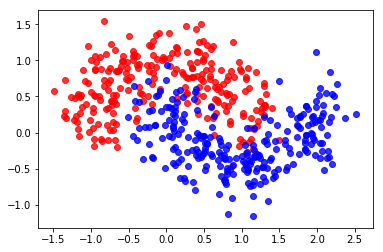

In [21]:
%matplotlib inline
from sklearn.datasets import make_classification, make_moons
import matplotlib.pyplot as plt
import numpy as np
def plot_clusters_2d(X, y):
    colors = ['r', 'b']
    for i in (0,1):
        idx = (y == i)
        plt.scatter(X[idx][:,0], 
                    X[idx][:,1], 
                    color = colors[i],
                   alpha=0.8)
        
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

def acc_loss_array(y_true, y_pred):
    return 1-np.mean(np.abs(y_true.reshape(1,-1) - y_pred.reshape(1,-1)))

def train_and_plot(clf, X, y, plot_points = True):
    #Shamelessly ripped off from 
    #http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    h = 0.01
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    clf.fit(X_train, y_train)
    #score = clf.score(X_test, y_test)

    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]

        # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # Plot also the training points
    if plot_points==True:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolor='k', alpha=0.25)
    #plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
    #            size=15, horizontalalignment='right')

    plt.show()

def print_scores(clf, X, y, X_test, y_test):
    print("In-Sample Accuracy: {0}".format(clf.score(X,y)))
    print("Test Set Accuracy: {0}".format(clf.score(X_test,y_test)))
    
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=1000, random_state=6, noise=0.25)
X, X_val, y, y_val = train_test_split(X,y, test_size=0.5)
X_test, y_test = make_moons(n_samples=500, random_state=1, noise = 0.25)


plot_clusters_2d(X, y)
plt.show()

What we want to do is predict which color a given dot will be, based on its position. It's harder than it looks, because (a) the decision boundary isn't a simple line, and (b) the dataset is _noisy_ (observe around $(0,0.25)$, where some additional blue points make the boundary less than cleanly separated).


## Logistic Regression
Logistic regression finds a linear equation which describes the _log odds_ of a given observation being a member of a class.
$$\ln(\text{odds}(x \text{ is red })) = \ln\left(\frac{p(x \text{ is red})}{p(x \text{ is not red})}\right) = \ln\left(\frac{p(x \text{ is red})}{1- p(x \text{ is red})}\right)$$
In order to make this a little more concrete, let's graph the log odds as a function of the probability that x is red.

The advantage of doing this is that the log odds range from $-\infty$ to $\infty$, so we can apply linear regression techniques without getting worried about straying out of the $(0,1)$ range that a probability should be in. The logistic regression we're interested in the one which most closely approximates the following (letting $p = p(x \text{ is red })$)

$$\ln(\text{odds}(p)) \approx \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$$

The specific function that the algorithm optimizes is somewhat complicated, so we'll gloss over it by saying that it first assumes the data were generated by the functional form, and then selects $\beta_{0}, \beta_{1}$, and $\beta_{2}$ which are the most likely to have occurred, given the data that we've seen. If you consider the logistic regressor as a pure classifier (returning 1 if $f(X) > 0.5$ and 0 otherwise), it describes a linear decision boundary along $x_{1}$ and $x_{2}$ such that the log-odds are 0.

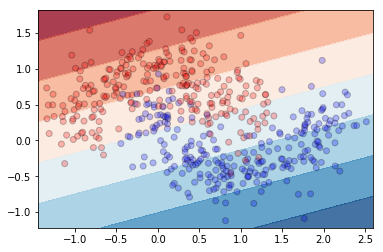

In-Sample Accuracy: 0.848
Test Set Accuracy: 0.85


In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

train_and_plot(clf, X, y)
print_scores(clf, X, y, X_val, y_val)


### Nope, pretty bad.

The problem is that since logistic regression is constrained to linear functions of the variables, it can't describe our moon shapes adequately. What if we added a bunch of polynomial features so that it was more capable of describing curves? Would our decision boundary look different then?

####  Cubic Decision Boundary:
Consider $f(x,y) = x+y$. Where's $f(x,y) = 0$?
Applying some algebra, the boundary is along $y = x$. Since logistic regression works by selecting $ay+bx+c$, all of the decision boundaries it can produce are lines.

Now think about $0 = x - x^2  +yx^2  + y^3$. Don't worry, we're not going to solve this by hand. The point is that this function is equal to zero along the following line:

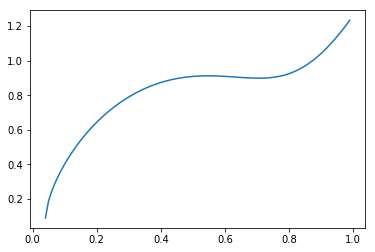

In [18]:
f = lambda x: 0.264567*((-27*x) + (27*x**2) + (729*((-1 + x)**2)*x**2 + 108*x**6))**(1/3)
xx = np.arange(0.04,1,0.01)
yy = np.vectorize(f)(xx) 
plt.plot(xx, yy)

#### Cubic Decison Boundary, Cont'd:
So, we've learned that we can have a much more complicated decision boundary if we allow polynomial inputs for $x_{i}$. The way that we actually get this done is rather than making the logistic regression more complicated, we compute polynomial values to expand the number of features we've included, and then treat them like additional linear variables in the regression.

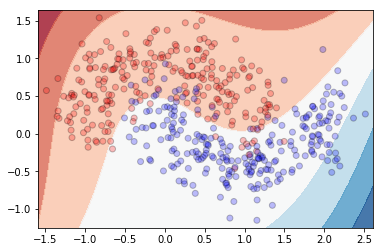

In-Sample Accuracy: 0.916
Test Set Accuracy: 0.936


In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

PF = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
pipe = Pipeline(steps = [('make_poly', PF),
                         ('clf', clf)])

train_and_plot(pipe, X, y)
print_scores(pipe, X, y, X_val, y_val)

Nice! Using a more complex function let us get way more accurate.